### Time Series Classification
#### An interesting task in machine learning is classification of time series. In this problem, we will classify the activities of humans based on time series obtained by a Wireless Sensor Network.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
import os


In [2]:
import rpy2
from rpy2.robjects.packages import importr

import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
pandas2ri.activate()
stats = importr('stats')
# import R's "base" package
base = importr('base')
# import R's "utils" package
utils = importr('utils')
# print(rpy2.__version__)

/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


#### (a) Download the AReM data from: https://archive.ics.uci.edu/ml/datasets/Activity+Recognition+system+based+on+Multisensor+data+fusion+\%28AReM\%29

In [3]:
# to split dataset

def split(times=1):
    directory = 'AReM'
    data = []
    for folder in [x[0] for x in os.walk(directory)][1:]:
        filelist = [i for i in os.listdir(folder) if i.endswith('.csv')]
        filelist = sorted(filelist, key=lambda s: int(s.split('.')[0][7:]))
        for file in filelist:
            if(folder+'/'+file=='AReM/bending2/dataset4.csv'):
                df = pd.read_csv(folder+'/'+file,skiprows=4)
                for i in range(len(df)):
                    df.iloc[i] = df.iloc[i,0].split(' ')[:7]
                df = df.astype('float64')
            else:
                df = pd.read_csv(folder+'/'+file,skiprows=4)
            df = df.iloc[:,1:]
            target = []
            if(times == 1):
                target = [df.describe().T.iloc[:,1:]]
            elif(times>1):
                stop = int(len(df)/times)
                for i in range(times):
                    target.append(df.iloc[:stop,:].describe().T.iloc[:,1:])
                    df = df.iloc[stop:,]
            row_data = [folder.split('/')[1],file]
            for target in target:
                for i in range(len(target)):
                    row_data = np.concatenate((row_data,np.around(target.iloc[i,:].astype('float64').values,3)))
            data.append(row_data)
    columns_label = []
    sample = ['mean({0})','std({0})','min({0})','1st quart({0})','median({0})','3st quart({0})','max({0})']
    for i in range(int(6*times)):
        columns_label += [a.format(i+1) for a in sample]
    columns_label.insert(0,'file')
    columns_label.insert(0,'activities')
    dataset = pd.DataFrame(data, index = range(1,89),columns = columns_label)
    dataset.index.name = "Instance"
    
    return dataset
    

#### (b) Keep datasets 1 and 2 in folders bending1 and bending 2, as well as datasets 1, 2, and 3 in other folders as test data and other datasets as train data.

In [4]:
#train test split

def train_test_split(dataset, option, activities):
    if(option == 'train'):
        if(activities=='bending1' or activities=='bending2'):
            sets = dataset[dataset['activities']==activities].iloc[2:,:]
        else:
            sets = dataset[dataset['activities']==activities].iloc[3:,:]
    elif(option == 'test'):
        if(activities=='bending1' or activities=='bending2'):
            sets = dataset[dataset['activities']==activities].iloc[:2,:]
        else:
            sets = dataset[dataset['activities']==activities].iloc[:3,:]
    return sets
            

#### (c) Feature Extraction
#### Classification of time series usually needs extracting features from them. In this problem, we focus on time-domain features.
##### i. Research what types of time-domain features are usually used in time series classification and list them (examples are minimum, maximum, mean, etc).



###### I think mean, median and max useful time-domain features

#### ii. Extract the time-domain features minimum, maximum, mean, median, standard deviation, first quartile, and third quartile for all of the 6 time series in each instance. You are free to normalize/standardize features or use them directly.

In [5]:
#feature extraction

def process_feature(dataset,nums = []):
    sample = ['mean({0})','median({0})','max({0})']
    f=[]
    if (len(nums)>0):
        for num in nums:
            f += [a.format(num) for a in sample]
            feature_df = dataset[['activities']+f]
    else:
        feature_df = dataset
    return feature_df
    

#### iii. Use your judgement to select the three most important time-domain features (one option may be min, mean, and max).

###### I think mean, median and max are three most important time-domain features

### (d) Binary Classification Using Logistic Regression3

In [6]:
#dataframe form train and test

def form_train_test_df(dataset):
    train_set = pd.DataFrame(columns = dataset.columns)
    test_set = pd.DataFrame(columns = dataset.columns)
    for a in dataset['activities'].unique():
#         print(a)
        train_set = train_set.append(train_test_split(dataset, 'train', a))
        test_set = test_set.append(train_test_split(dataset, 'test', a))
    return [train_set,test_set]

In [7]:
def change_label(dataset):
    dataset['activities'].loc[(dataset['activities']=='bending1')|(dataset['activities']=='bending2')] = 0
    dataset['activities'].loc[(dataset['activities']!=0)] = 1
    

In [8]:
#split data
dataset_1 = split()
display(dataset_1)

,activities,file,mean(1),std(1),min(1),1st quart(1),median(1),3st quart(1),max(1),mean(2),...,median(5),3st quart(5),max(5),mean(6),std(6),min(6),1st quart(6),median(6),3st quart(6),max(6)
Instance,,,,,,,,,,,,,,,,,,,,,
1,bending1,dataset1.csv,40.625,1.477,37.25,39.25,40.5,42.0,45.0,0.359,...,35.0,36.0,38.25,0.571,0.583,0.0,0.0,0.43,1.3,1.92
2,bending1,dataset2.csv,42.813,1.436,38.0,42.0,42.5,43.67,45.67,0.372,...,33.0,34.5,38.5,0.571,0.601,0.0,0.0,0.43,1.3,3.11
3,bending1,dataset3.csv,43.954,1.559,35.0,43.0,44.33,45.0,47.4,0.426,...,36.0,36.5,38.5,0.493,0.514,0.0,0.0,0.43,0.94,1.79
4,bending1,dataset4.csv,42.18,3.671,33.0,39.15,43.5,45.0,47.75,0.696,...,35.0,36.33,38.67,0.614,0.524,0.0,0.0,0.5,1.0,2.18
5,bending1,dataset5.csv,41.678,2.243,33.0,41.33,41.75,42.75,45.75,0.536,...,30.0,31.25,37.5,0.383,0.389,0.0,0.0,0.43,0.5,1.79
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,cycling,dataset11.csv,36.542,4.019,27.0,33.25,36.0,39.812,44.33,2.848,...,16.75,19.5,24.5,3.225,1.77,0.0,1.885,2.87,4.262,9.18
85,cycling,dataset12.csv,35.752,4.615,18.5,33.0,36.0,39.33,44.25,3.328,...,16.25,18.062,24.33,3.07,1.748,0.0,1.798,2.77,4.06,9.39
86,cycling,dataset13.csv,35.88,4.615,19.0,33.0,36.0,39.5,43.75,3.414,...,17.0,19.69,26.5,3.093,1.626,0.0,1.89,2.93,4.06,8.5


In [9]:
#form training and testing data
train_set_1 = form_train_test_df(dataset_1)[0]
test_set_1 = form_train_test_df(dataset_1)[1]
display(train_set_1)
display(test_set_1)

,activities,file,mean(1),std(1),min(1),1st quart(1),median(1),3st quart(1),max(1),mean(2),...,median(5),3st quart(5),max(5),mean(6),std(6),min(6),1st quart(6),median(6),3st quart(6),max(6)
3,bending1,dataset3.csv,43.954,1.559,35.0,43.0,44.33,45.0,47.4,0.426,...,36.0,36.5,38.5,0.493,0.514,0.0,0.0,0.43,0.94,1.79
4,bending1,dataset4.csv,42.18,3.671,33.0,39.15,43.5,45.0,47.75,0.696,...,35.0,36.33,38.67,0.614,0.524,0.0,0.0,0.5,1.0,2.18
5,bending1,dataset5.csv,41.678,2.243,33.0,41.33,41.75,42.75,45.75,0.536,...,30.0,31.25,37.5,0.383,0.389,0.0,0.0,0.43,0.5,1.79
6,bending1,dataset6.csv,43.455,1.386,37.0,42.5,43.25,45.0,48.0,0.378,...,23.5,24.0,33.5,0.68,0.623,0.0,0.43,0.5,0.87,5.26
7,bending1,dataset7.csv,43.969,1.618,36.25,43.31,44.5,44.67,48.0,0.413,...,21.67,23.75,30.75,0.555,0.488,0.0,0.0,0.49,0.83,2.96
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,cycling,dataset11.csv,36.542,4.019,27.0,33.25,36.0,39.812,44.33,2.848,...,16.75,19.5,24.5,3.225,1.77,0.0,1.885,2.87,4.262,9.18
85,cycling,dataset12.csv,35.752,4.615,18.5,33.0,36.0,39.33,44.25,3.328,...,16.25,18.062,24.33,3.07,1.748,0.0,1.798,2.77,4.06,9.39
86,cycling,dataset13.csv,35.88,4.615,19.0,33.0,36.0,39.5,43.75,3.414,...,17.0,19.69,26.5,3.093,1.626,0.0,1.89,2.93,4.06,8.5
87,cycling,dataset14.csv,36.244,3.822,23.33,33.457,36.75,39.25,43.5,2.736,...,18.5,21.0,27.0,3.53,1.964,0.0,2.17,3.11,4.618,11.15


,activities,file,mean(1),std(1),min(1),1st quart(1),median(1),3st quart(1),max(1),mean(2),...,median(5),3st quart(5),max(5),mean(6),std(6),min(6),1st quart(6),median(6),3st quart(6),max(6)
1,bending1,dataset1.csv,40.625,1.477,37.25,39.25,40.5,42.0,45.0,0.359,...,35.0,36.0,38.25,0.571,0.583,0.0,0.0,0.43,1.3,1.92
2,bending1,dataset2.csv,42.813,1.436,38.0,42.0,42.5,43.67,45.67,0.372,...,33.0,34.5,38.5,0.571,0.601,0.0,0.0,0.43,1.3,3.11
8,walking,dataset1.csv,34.228,4.89,19.33,30.5,35.5,37.75,43.5,3.996,...,16.67,18.67,26.0,3.394,1.792,0.0,2.105,3.1,4.425,9.74
9,walking,dataset2.csv,33.51,4.851,12.5,30.5,34.125,36.75,45.0,4.451,...,16.75,18.75,25.0,3.378,1.787,0.0,2.06,3.085,4.44,8.96
10,walking,dataset3.csv,34.661,5.315,15.0,31.0,35.0,38.25,46.75,4.201,...,16.33,18.5,24.5,3.244,1.631,0.0,2.12,3.0,4.24,8.99
23,bending2,dataset1.csv,24.563,3.738,12.75,23.188,24.25,26.5,51.0,0.591,...,23.75,27.0,30.0,0.7,0.694,0.0,0.43,0.5,0.87,4.97
24,bending2,dataset2.csv,27.465,3.584,0.0,25.5,28.0,30.0,42.75,0.45,...,18.0,20.75,33.0,1.122,1.012,0.0,0.47,0.83,1.3,6.76
29,standing,dataset1.csv,44.335,2.477,33.33,42.25,45.0,46.5,48.0,0.433,...,14.75,17.75,23.0,0.933,0.674,0.0,0.47,0.83,1.25,5.02
30,standing,dataset2.csv,43.175,1.989,35.5,42.5,43.67,44.5,46.25,0.507,...,14.67,16.5,21.25,0.912,0.666,0.0,0.47,0.83,1.22,5.72
31,standing,dataset3.csv,42.761,3.399,32.75,41.33,44.5,45.372,47.0,0.486,...,16.585,18.565,21.33,0.842,0.722,0.0,0.43,0.71,1.09,5.73


In [10]:
#change label
change_label(train_set_1)
change_label(test_set_1)
display(train_set_1)
display(test_set_1)


,activities,file,mean(1),std(1),min(1),1st quart(1),median(1),3st quart(1),max(1),mean(2),...,median(5),3st quart(5),max(5),mean(6),std(6),min(6),1st quart(6),median(6),3st quart(6),max(6)
3,0,dataset3.csv,43.954,1.559,35.0,43.0,44.33,45.0,47.4,0.426,...,36.0,36.5,38.5,0.493,0.514,0.0,0.0,0.43,0.94,1.79
4,0,dataset4.csv,42.18,3.671,33.0,39.15,43.5,45.0,47.75,0.696,...,35.0,36.33,38.67,0.614,0.524,0.0,0.0,0.5,1.0,2.18
5,0,dataset5.csv,41.678,2.243,33.0,41.33,41.75,42.75,45.75,0.536,...,30.0,31.25,37.5,0.383,0.389,0.0,0.0,0.43,0.5,1.79
6,0,dataset6.csv,43.455,1.386,37.0,42.5,43.25,45.0,48.0,0.378,...,23.5,24.0,33.5,0.68,0.623,0.0,0.43,0.5,0.87,5.26
7,0,dataset7.csv,43.969,1.618,36.25,43.31,44.5,44.67,48.0,0.413,...,21.67,23.75,30.75,0.555,0.488,0.0,0.0,0.49,0.83,2.96
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,1,dataset11.csv,36.542,4.019,27.0,33.25,36.0,39.812,44.33,2.848,...,16.75,19.5,24.5,3.225,1.77,0.0,1.885,2.87,4.262,9.18
85,1,dataset12.csv,35.752,4.615,18.5,33.0,36.0,39.33,44.25,3.328,...,16.25,18.062,24.33,3.07,1.748,0.0,1.798,2.77,4.06,9.39
86,1,dataset13.csv,35.88,4.615,19.0,33.0,36.0,39.5,43.75,3.414,...,17.0,19.69,26.5,3.093,1.626,0.0,1.89,2.93,4.06,8.5
87,1,dataset14.csv,36.244,3.822,23.33,33.457,36.75,39.25,43.5,2.736,...,18.5,21.0,27.0,3.53,1.964,0.0,2.17,3.11,4.618,11.15


,activities,file,mean(1),std(1),min(1),1st quart(1),median(1),3st quart(1),max(1),mean(2),...,median(5),3st quart(5),max(5),mean(6),std(6),min(6),1st quart(6),median(6),3st quart(6),max(6)
1,0,dataset1.csv,40.625,1.477,37.25,39.25,40.5,42.0,45.0,0.359,...,35.0,36.0,38.25,0.571,0.583,0.0,0.0,0.43,1.3,1.92
2,0,dataset2.csv,42.813,1.436,38.0,42.0,42.5,43.67,45.67,0.372,...,33.0,34.5,38.5,0.571,0.601,0.0,0.0,0.43,1.3,3.11
8,1,dataset1.csv,34.228,4.89,19.33,30.5,35.5,37.75,43.5,3.996,...,16.67,18.67,26.0,3.394,1.792,0.0,2.105,3.1,4.425,9.74
9,1,dataset2.csv,33.51,4.851,12.5,30.5,34.125,36.75,45.0,4.451,...,16.75,18.75,25.0,3.378,1.787,0.0,2.06,3.085,4.44,8.96
10,1,dataset3.csv,34.661,5.315,15.0,31.0,35.0,38.25,46.75,4.201,...,16.33,18.5,24.5,3.244,1.631,0.0,2.12,3.0,4.24,8.99
23,0,dataset1.csv,24.563,3.738,12.75,23.188,24.25,26.5,51.0,0.591,...,23.75,27.0,30.0,0.7,0.694,0.0,0.43,0.5,0.87,4.97
24,0,dataset2.csv,27.465,3.584,0.0,25.5,28.0,30.0,42.75,0.45,...,18.0,20.75,33.0,1.122,1.012,0.0,0.47,0.83,1.3,6.76
29,1,dataset1.csv,44.335,2.477,33.33,42.25,45.0,46.5,48.0,0.433,...,14.75,17.75,23.0,0.933,0.674,0.0,0.47,0.83,1.25,5.02
30,1,dataset2.csv,43.175,1.989,35.5,42.5,43.67,44.5,46.25,0.507,...,14.67,16.5,21.25,0.912,0.666,0.0,0.47,0.83,1.22,5.72
31,1,dataset3.csv,42.761,3.399,32.75,41.33,44.5,45.372,47.0,0.486,...,16.585,18.565,21.33,0.842,0.722,0.0,0.43,0.71,1.09,5.73


In [11]:
# dataset_1.to_csv('raw.csv')
# train_set_1.to_csv('train.csv')

#### i. Assume that you want to use the training set to classify bending from other activities, i.e. you have a binary classification problem. Depict scatter plots of the features you specified in 1(c)iii extracted from time series 1, 2, and 6 of each instance, and use color to distinguish bending vs. other activities. (See p. 129 of the textbook).

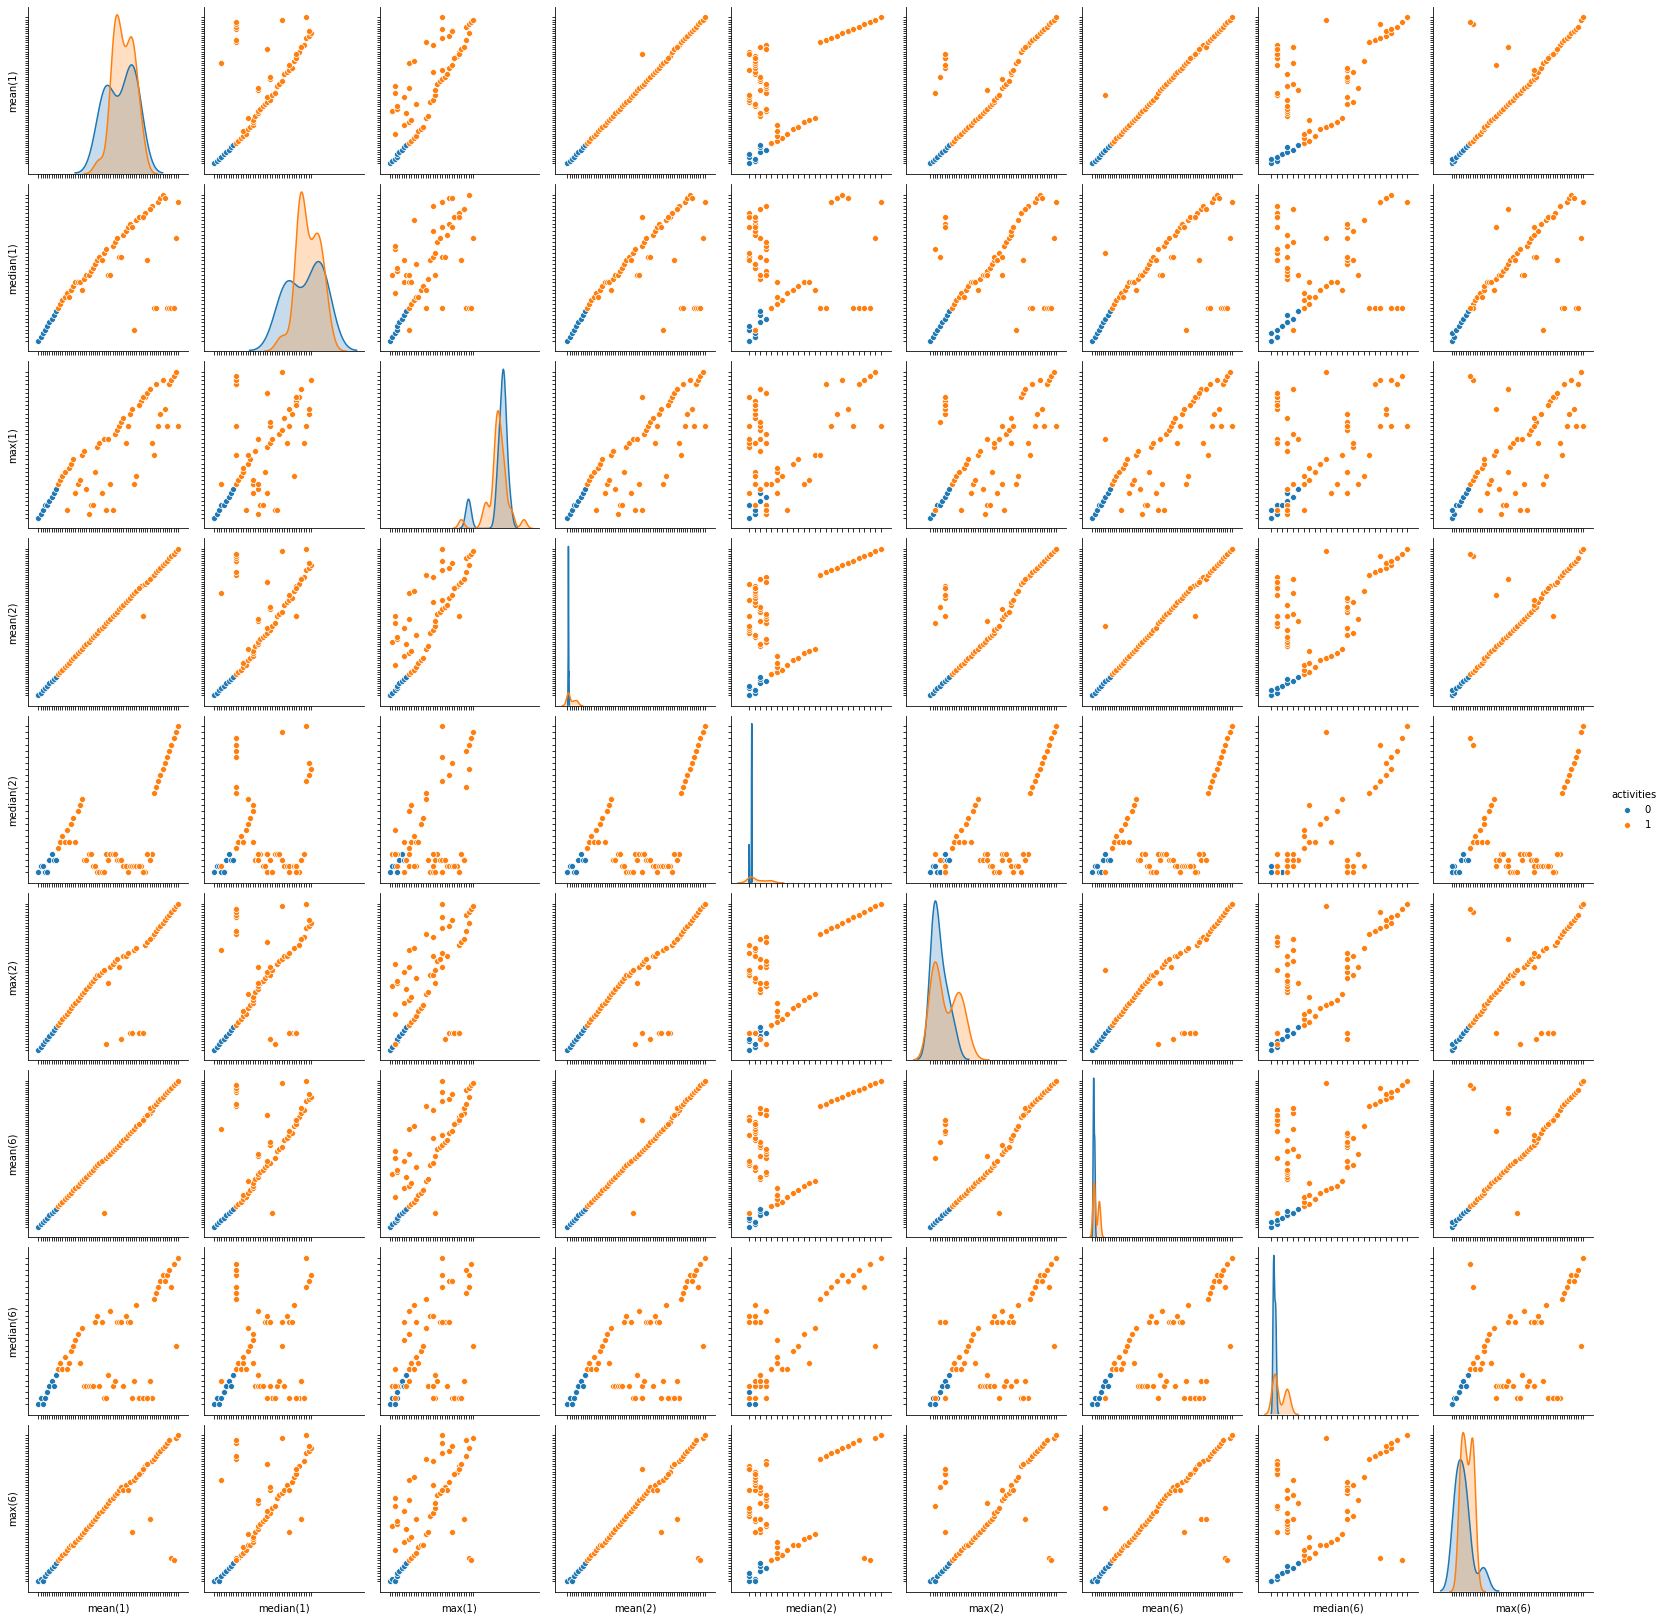

In [12]:
three_factor_df126 = process_feature(train_set_1,[1,2,6])
# display(three_factor_df126)
g = sns.pairplot(three_factor_df126, hue="activities")
g.set(xticklabels=[])
g.set(yticklabels=[])    

#### ii. Break each time series in your training set into two (approximately) equal length time series. Now instead of 6 time series for each of the training instances, you have 12 time series for each training instance. Repeat the experiment in 1(d)i, i.e depict scatter plots of the features extracted from both parts of the time series 1,2, and 12. Do you see any considerable difference in the results with those of 1(d)i?

In [13]:
#split data
dataset_2 = split(2)
# display(dataset_2)

#form train and test
train_set_2 = form_train_test_df(dataset_2)[0]
test_set_2 = form_train_test_df(dataset_2)[1]
change_label(train_set_2)
change_label(test_set_2)
# display(train_set_2)
# display(test_set_2)

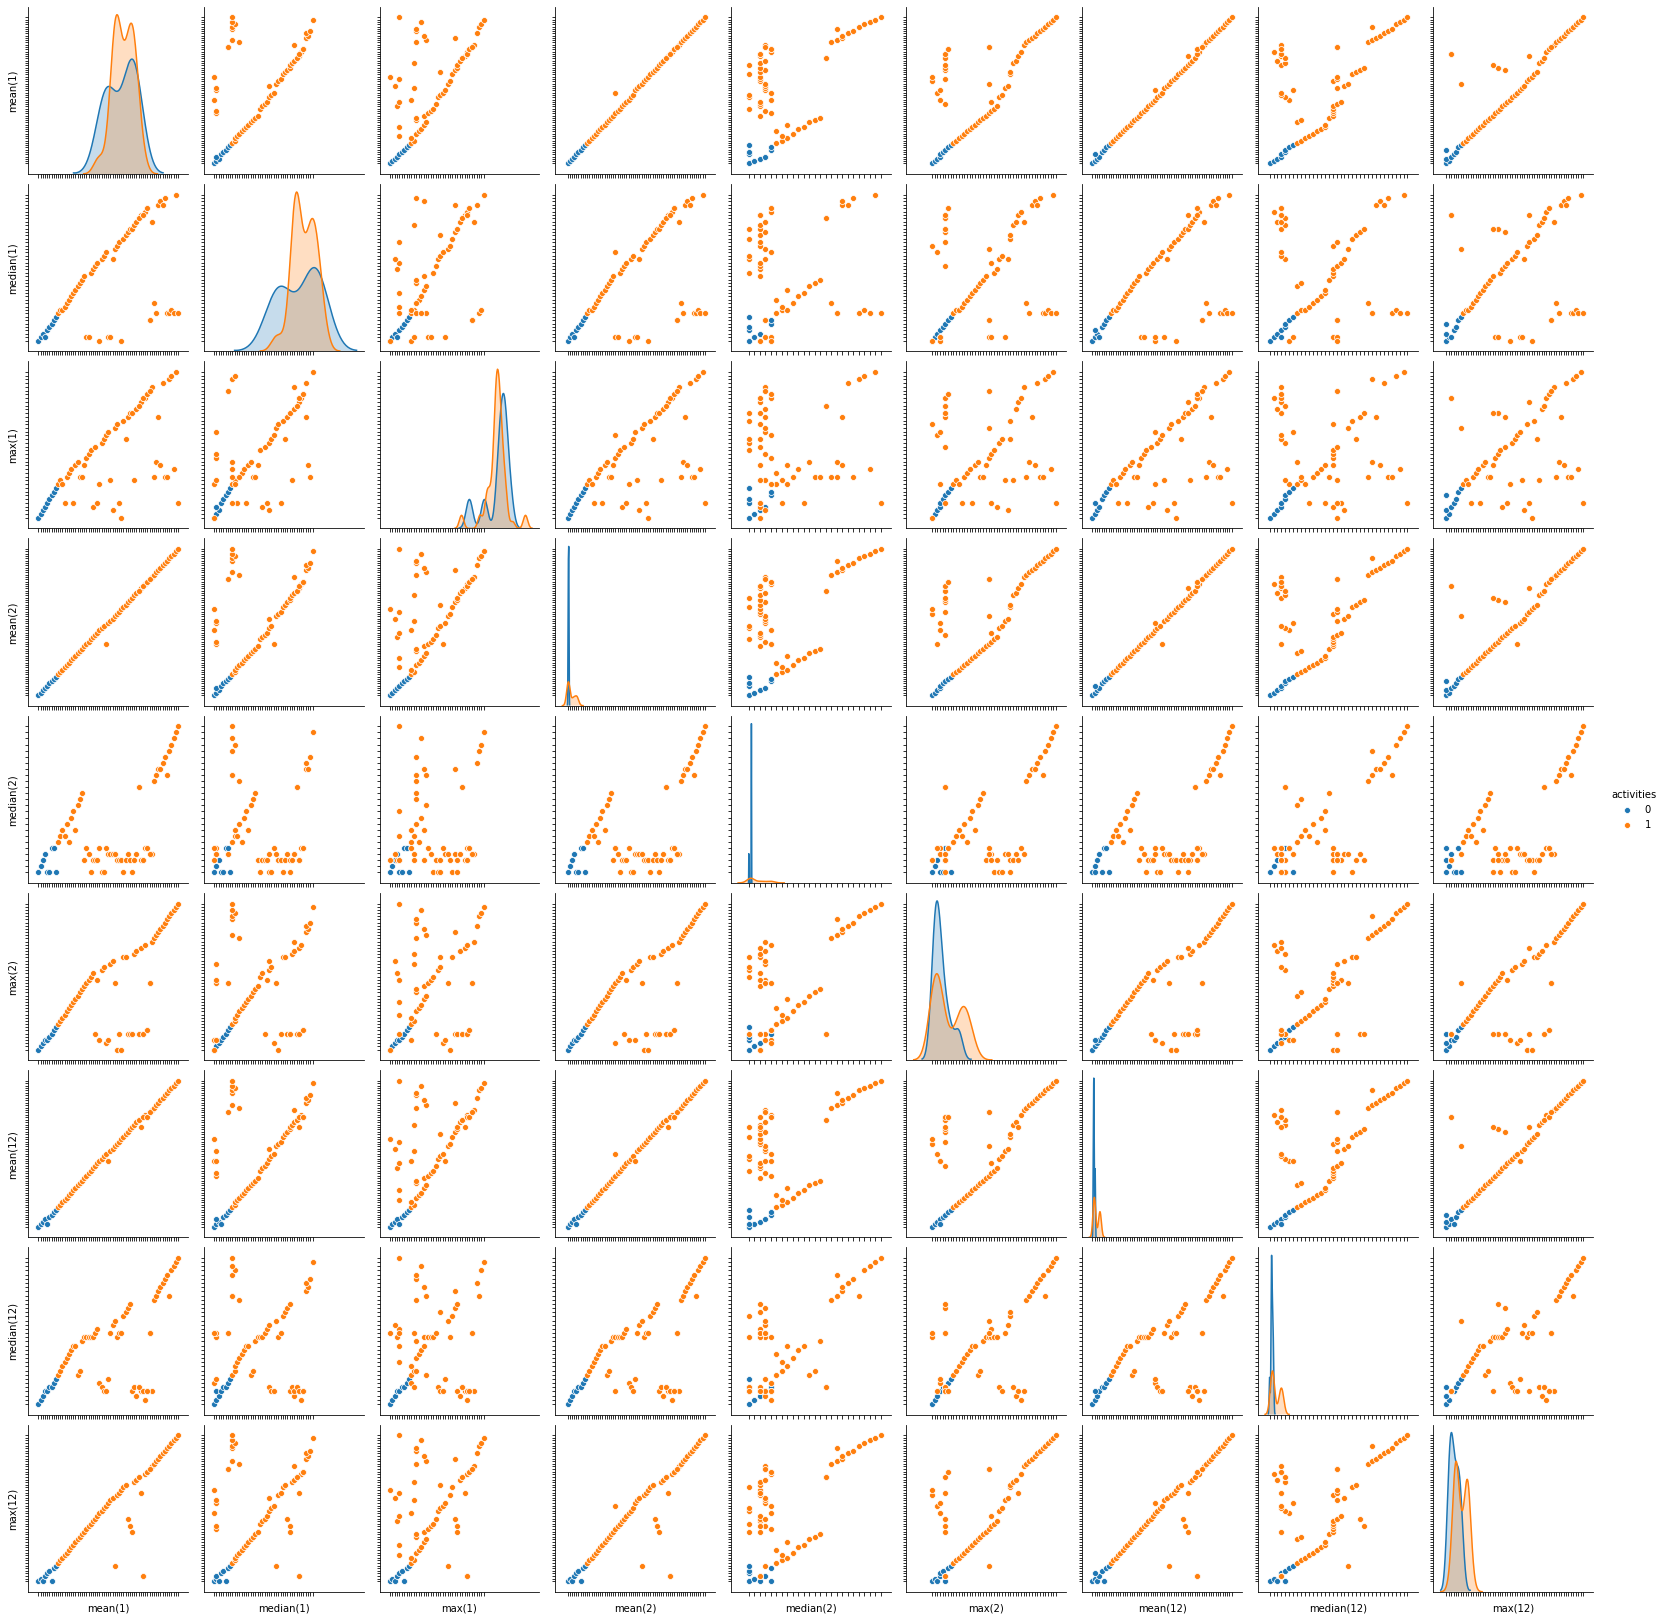

In [14]:
three_factor_df1212 = process_feature(train_set_2,[1,2,12])
# display(three_factor_df1212)
g = sns.pairplot(three_factor_df1212, hue="activities")
g.set(xticklabels=[])
g.set(yticklabels=[])

###### No considerable difference to the result of 1(d)i

In [15]:
train_data_split = []
for i in range(1,21):
#     display(form_train_test_df(split(i))[0])
    train_data_split.append(form_train_test_df(split(i))[0])


In [16]:
#change label
for t in train_data_split:
    change_label(t)
#     display(t)

#### iii Break each time series in your training set into l ∈ {1, 2, . . . , 20} time series of approximately equal length and use logistic regression to solve the binary classification problem, using time-domain features. Calculate the p-values for your logistic regression parameters and refit a logistic regression model using your pruned set of features. Alternatively, you can use backward selection using sklearn.feature selection or glm in R. Use 5-fold cross-validation to de- termine the best value of l. Explain what the right way and the wrong way are to perform cross-validation in this problem. Obviously, use the right way! Also, you may encounter the problem of class imbalance, which may make some of your folds not having any instances of the rare class. In such a case, you can use stratified cross validation. Research what it means and use it if needed.¶


In [17]:
def grid_search_cv():
    res=0
    best_l = 0
    best_k_feature = []
    best_score =[]
    
    for i in range(1,21):
        train_data = train_data_split[i-1]
        X_train=train_data.iloc[:,2:]
        min_max_scaler = MinMaxScaler()
        X_train_normalized=min_max_scaler.fit_transform(X_train)
        Y_train=train_data.iloc[:,0].astype('float')
        
        cv_score=0
        current_best_k=0
        current_best_feature_number=0
        
        model=LogisticRegressionCV(cv=5)
        rfe = RFECV(model, cv=5)

        rfe.fit(X_train_normalized,Y_train) #refit the model using selected feature
        ranking_list=rfe.support_

        feature_list=X_train.columns.values[ranking_list]

        new_X_train=X_train[feature_list]
#         Y_train=train_data.iloc[:,0]

        min_max_scaler = MinMaxScaler()
        new_X_train_normalized=min_max_scaler.fit_transform(new_X_train)

        Log=LogisticRegressionCV(cv=5)
#         scores = cross_val_score(Log,new_X_train_normalized ,Y_train, cv=5)
#         avg_scores=np.mean(scores)
        new_model= Log.fit(new_X_train_normalized,Y_train)
        avg_scores=new_model.score(new_X_train_normalized,Y_train)
        
        print('accuracy is {0}'.format(avg_scores))
        print('(l,p) pair is ({0},{1})'.format(i,len(feature_list)))
        print(feature_list)
        
        if(avg_scores>res):
            best_l = i
            res = avg_scores
            best_k_feature = feature_list
        
    print('Best accuracy is {0}'.format(res))
    print('Best (l,p) pair is ({0},{1})'.format(best_l,len(best_k_feature)))
    
                
    return [best_l,best_k_feature,res]
#     return current_list



###### We know that best pair is (4,7) with Score of 1.0

#### Explain what the right way and the wrong way are to perform cross-validation in this problem

###### Correct Way:According to the above experiment,we can find that the correct procedure to choose the cross validation result is set different parameters, and then use cross-validation to guide us to pick the correct parameters.

#### iv. Report the confusion matrix and show the ROC and AUC for your classifier on train data. Report the parameters of your logistic regression βi’s as well as the p-values associated with them.

In [18]:
train_data = train_data_split[3].drop(['file'],axis=1).astype('float')
train_x = train_data[['mean(5)','1st quart(5)','3st quart(5)','max(5)','median(13)','3st quart(13)','1st quart(16)']]
train_y = train_data.iloc[:,0]

# display(train_x)
# display(train_y)

model=LogisticRegressionCV(cv=5)
min_max_scaler = MinMaxScaler()
X_train_normalized = min_max_scaler.fit_transform(train_x)
model.fit(X_train_normalized,train_y)

LogisticRegressionCV(cv=5)

In [19]:
model.predict(X_train_normalized)

print('Accuracy is {0}'.format(model.score(X_train_normalized,train_y)))
print('confusion matrix is ')
confusion_matrix(model.predict(X_train_normalized),train_y)

Accuracy is 1.0
confusion matrix is 


array([[ 9,  0],
       [ 0, 60]])

roc_auc score is 1.0


Text(0, 0.5, 'TPR')

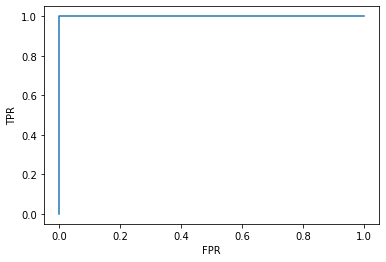

In [20]:
probs=model.predict_proba(X_train_normalized)
preds = probs[:,1]
# print(preds)
fpr, tpr, threshold = metrics.roc_curve(train_y, preds)
roc_auc = metrics.auc(fpr, tpr)
print("roc_auc score is {0}".format(roc_auc))
df = pd.DataFrame(dict(fpr = fpr, tpr = tpr))
plt.plot(fpr,tpr)
plt.xlabel("FPR")
plt.ylabel("TPR")

In [21]:
train_set = train_x
train_set['label'] = train_y
# display(train_set)
dataf = ro.DataFrame({})
dataf = pandas2ri.py2ri(train_set)
# print(dataf)

/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [22]:
formula = 'label ~ .'
full_fit = stats.glm(formula, data = dataf, family = "binomial")
# ro.r('''mylogit <- glm(label ~ ., data = dataf, family = "binomial")''')

##### p-value

In [23]:
print(base.summary(full_fit))


Call:
(function (formula, family = gaussian, data, weights, subset, 
    na.action, start = NULL, etastart, mustart, offset, control = list(...), 
    model = TRUE, method = "glm.fit", x = FALSE, y = TRUE, contrasts = NULL, 
    ...) 
{
    call <- match.call()
    if (is.character(family)) 
        family <- get(family, mode = "function", envir = parent.frame())
    if (is.function(family)) 
        family <- family()
    if (is.null(family$family)) {
        print(family)
        stop("'family' not recognized")
    }
    if (missing(data)) 
        data <- environment(formula)
    mf <- match.call(expand.dots = FALSE)
    m <- match(c("formula", "data", "subset", "weights", "na.action", 
        "etastart", "mustart", "offset"), names(mf), 0L)
    mf <- mf[c(1L, m)]
    mf$drop.unused.levels <- TRUE
    mf[[1L]] <- quote(stats::model.frame)
    mf <- eval(mf, parent.frame())
    if (identical(method, "model.frame")) 
        return(mf)
    if (!is.character(method) && !is.function(m

#### V. Test the classifier on the test set. Remember to break the time series in your test set into the same number of time series into which you broke your training set. Remember that the classifier has to be tested using the features extracted from the test set. Compare the accuracy on the test set with the cross-validation accuracy you obtained previously.

In [24]:
test_data = form_train_test_df(split(4))[1].drop(['file'],axis=1)
change_label(test_data)
test_data = test_data.astype('float')

test_x = test_data[['mean(5)','1st quart(5)','3st quart(5)','max(5)','median(13)','3st quart(13)','1st quart(16)']]
test_y = test_data.iloc[:,0]

display(test_x)
display(test_y)

model=LogisticRegressionCV(cv=5)
min_max_scaler = MinMaxScaler()
X_test_normalized = min_max_scaler.fit_transform(test_x)
model.fit(X_test_normalized,test_y)

,mean(5),1st quart(5),3st quart(5),max(5),median(13),3st quart(13),1st quart(16)
1,33.748,33.000,34.500,36.00,39.000,39.330,0.430
2,33.267,32.500,34.000,36.00,42.000,42.000,0.430
8,16.379,14.330,18.372,25.00,35.250,37.670,2.102
9,16.265,14.188,18.372,25.00,34.000,36.543,2.102
10,16.248,14.188,18.062,23.75,36.500,40.250,1.690
23,26.133,25.250,27.000,28.33,23.500,24.000,0.430
24,16.780,15.310,18.250,21.50,27.000,29.270,0.000
29,17.946,16.938,20.000,22.60,42.000,45.250,0.000
30,14.722,12.750,17.000,18.50,43.900,44.500,0.300
31,16.397,15.000,18.250,21.00,45.000,45.500,0.000


1     0.0
2     0.0
8     1.0
9     1.0
10    1.0
23    0.0
24    0.0
29    1.0
30    1.0
31    1.0
44    1.0
45    1.0
46    1.0
59    1.0
60    1.0
61    1.0
74    1.0
75    1.0
76    1.0
Name: activities, dtype: float64

/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


LogisticRegressionCV(cv=5)

In [25]:
print('Accuracy is {0}'.format(model.score(X_test_normalized,test_y)))
print("Previous score is 1.0")

Accuracy is 0.9473684210526315
Previous score is 1.0


##### vi. Do your classes seem to be well-separated to cause instability in calculating logistic regression parameters?

###### YES, that happen because of imbalance datasets, then we will use the oversampling tech to solve this problem

In [26]:
print('confusion matrix is ')
confusion_matrix(model.predict(X_test_normalized),test_y)

confusion matrix is 


array([[ 3,  0],
       [ 1, 15]])

#### vii. From the confusion matrices you obtained, do you see imbalanced classes? If yes, build a logistic regression model based on case-control sampling and adjust its parameters. Report the confusion matrix, ROC, and AUC of the model.

###### Yes, bending is the imbalanced classes


In [27]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score
from imblearn.over_sampling import SMOTE

In [28]:
display(test_x)
display(test_y)

,mean(5),1st quart(5),3st quart(5),max(5),median(13),3st quart(13),1st quart(16)
1,33.748,33.000,34.500,36.00,39.000,39.330,0.430
2,33.267,32.500,34.000,36.00,42.000,42.000,0.430
8,16.379,14.330,18.372,25.00,35.250,37.670,2.102
9,16.265,14.188,18.372,25.00,34.000,36.543,2.102
10,16.248,14.188,18.062,23.75,36.500,40.250,1.690
23,26.133,25.250,27.000,28.33,23.500,24.000,0.430
24,16.780,15.310,18.250,21.50,27.000,29.270,0.000
29,17.946,16.938,20.000,22.60,42.000,45.250,0.000
30,14.722,12.750,17.000,18.50,43.900,44.500,0.300
31,16.397,15.000,18.250,21.00,45.000,45.500,0.000


1     0.0
2     0.0
8     1.0
9     1.0
10    1.0
23    0.0
24    0.0
29    1.0
30    1.0
31    1.0
44    1.0
45    1.0
46    1.0
59    1.0
60    1.0
61    1.0
74    1.0
75    1.0
76    1.0
Name: activities, dtype: float64

In [29]:
#use over-sampling method
train_data = train_data_split[3].drop(['file'],axis=1).astype('float')
train_x = train_data[['mean(5)','1st quart(5)','3st quart(5)','max(5)','median(13)','3st quart(13)','1st quart(16)']]
train_y = train_data.iloc[:,0]
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(train_x, train_y)

In [30]:
display(X_resampled)
display(y_resampled)

,mean(5),1st quart(5),3st quart(5),max(5),median(13),3st quart(13),1st quart(16)
0,35.990,36.000,36.500,37.50,45.00,45.062,0.000
1,36.624,36.000,37.500,38.67,42.00,44.312,0.470
2,29.119,27.500,30.000,35.25,42.00,42.270,0.322
3,24.504,23.458,25.562,33.50,42.67,43.500,0.000
4,23.592,20.500,30.000,30.75,44.50,44.670,0.000
...,...,...,...,...,...,...,...
115,23.592,20.500,30.000,30.75,44.50,44.670,0.000
116,22.113,17.938,27.812,33.50,33.00,33.150,0.000
117,22.113,17.938,27.812,33.50,33.00,33.150,0.000
118,18.828,17.670,20.000,23.25,29.25,30.000,0.000


0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
115    0.0
116    0.0
117    0.0
118    0.0
119    0.0
Name: activities, Length: 120, dtype: float64

Accuracy is 1.0
confusion matrix is 
[[ 4  0]
 [ 0 15]]
roc_auc score is 1.0


Text(0, 0.5, 'TPR')

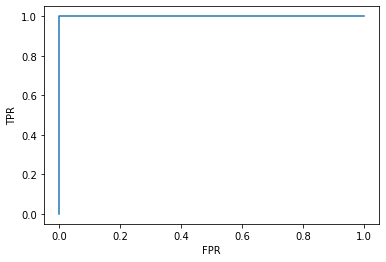

In [31]:
model=LogisticRegression()
model.fit(X_resampled,y_resampled)
print('Accuracy is {0}'.format(model.score(test_x,test_y)))
print('confusion matrix is ')
print(confusion_matrix(model.predict(test_x),test_y))

probs=model.predict_proba(test_x)
preds = probs[:,1]
# print(preds)
fpr, tpr, threshold = metrics.roc_curve(test_y, preds)
roc_auc = metrics.auc(fpr, tpr)
print("roc_auc score is {0}".format(roc_auc))
df = pd.DataFrame(dict(fpr = fpr, tpr = tpr))
plt.plot(fpr,tpr)
plt.xlabel("FPR")
plt.ylabel("TPR")

### (e) Binary Classification Using L1-penalized logistic regression

#### i. Repeat 1(d)iii using L1-penalized logistic regression,8 i.e. instead of using p-values for variable selection, use L1 regularization. Note that in this problem, you have to cross-validate for both l, the number of time series into which you break each of your instances, and λ, the weight of L1 penalty in your logistic regression objective function (or C, the budget). Packages usually perform cross-validation for λ automatically.

In [32]:
def logistic_grid_search_cv():
    res=0
    best_k_number=0
    best_lambda=0
    current_list=[]
    
    #i is the number of Time Seires, J is the number of Lambda we choose
    for i in range(1,21):
        df = train_data_split[i-1]
        
        X_train=df.iloc[:,2:].astype('float')
        min_max_scaler = MinMaxScaler()
        X_train_normalized=min_max_scaler.fit_transform(X_train)
        Y_train=df.iloc[:,0].astype('float')
        
        cv_score=0
        current_best_k=0
        current_best_feature_number=0
        
        
        for j in np.arange(1,100):
            model=LogisticRegression(penalty="l1",C=1/j,solver = 'liblinear')
            scores = cross_val_score(model,X_train_normalized ,Y_train, cv=5)
            avg_scores=np.mean(scores)
#             print("When Time Series ="+str(i)+", Lasso Regualize Lambda ="+str(j)+" CV scores is"+str(avg_scores))
            
            if avg_scores>res:
                res=avg_scores
                best_k_number=i
                best_lambda=j
                
    current_list.append((res,best_k_number,best_lambda))
            
                
                
    return current_list

Lasso_Res=logistic_grid_search_cv()
print(Lasso_Res)

[(0.9131868131868132, 13, 1)]


#### ii. Compare the L1-penalized with variable selection using p-values. Which one performs better? Which one is easier to implement?

###### From The above result, we can find that L1 Regualizer is much easier to implement because it did not have the process of feature selection, it can Automatically select the feature. Also The best Accuracy score is 91.32% which is lower than the RTFCV best Accuracy is 1.0

In [33]:
#train test split

def train_test_split(dataset, option, activities):
    if(option == 'train'):
        if(activities=='bending1' or activities=='bending2'):
            sets = dataset[dataset['activities']==activities].iloc[2:,:]
        else:
            sets = dataset[dataset['activities']==activities].iloc[3:,:]
    elif(option == 'test'):
        if(activities=='bending1' or activities=='bending2'):
            sets = dataset[dataset['activities']==activities].iloc[:2,:]
        else:
            sets = dataset[dataset['activities']==activities].iloc[:3,:]
    return sets
            

In [34]:
#dataframe form train and test

def form_train_test_df(dataset):
    train_set = pd.DataFrame(columns = dataset.columns)
    test_set = pd.DataFrame(columns = dataset.columns)
    for a in dataset['activities'].unique():
#         print(a)
        train_set = train_set.append(train_test_split(dataset, 'train', a))
        test_set = test_set.append(train_test_split(dataset, 'test', a))
    return [train_set,test_set]

In [35]:
train_data_split = []
for i in range(1,21):
    df = split(i).drop(['file'],axis=1)
    train_data_split.append(form_train_test_df(df)[0])


In [36]:
display(train_data_split[1])

,activities,mean(1),std(1),min(1),1st quart(1),median(1),3st quart(1),max(1),mean(2),std(2),...,median(11),3st quart(11),max(11),mean(12),std(12),min(12),1st quart(12),median(12),3st quart(12),max(12)
3,bending1,44.057,1.557,36.5,43.25,44.5,45.0,46.5,0.381,0.33,...,36.0,36.25,38.25,0.388,0.479,0.0,0.0,0.0,0.71,1.5
4,bending1,43.279,3.473,33.75,42.0,45.0,45.25,47.75,0.673,0.634,...,30.415,33.75,38.5,0.586,0.492,0.0,0.0,0.47,0.87,2.18
5,bending1,41.621,3.119,33.0,39.652,42.33,44.25,45.75,0.623,0.49,...,29.75,30.562,36.0,0.348,0.363,0.0,0.0,0.43,0.5,1.5
6,bending1,44.117,1.36,39.0,43.5,45.0,45.0,48.0,0.25,0.314,...,23.25,23.75,26.0,0.544,0.473,0.0,0.43,0.5,0.71,4.06
7,bending1,43.486,1.282,36.67,42.33,43.71,44.5,45.0,0.379,0.284,...,21.75,23.5,26.0,0.586,0.488,0.0,0.422,0.5,0.83,2.96
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,cycling,36.645,4.054,27.67,33.188,36.0,40.27,44.33,2.826,1.925,...,16.67,19.062,23.33,3.207,1.879,0.0,1.79,2.68,4.222,9.18
85,cycling,35.692,4.644,20.0,33.0,35.5,39.25,44.25,3.324,2.162,...,16.5,18.25,24.33,2.967,1.712,0.0,1.852,2.59,3.74,8.81
86,cycling,35.694,4.778,19.0,33.188,36.0,39.562,43.75,3.658,2.35,...,18.0,20.5,26.5,2.937,1.562,0.0,1.7,2.74,3.7,7.89
87,cycling,36.343,3.648,27.0,33.67,36.75,39.0,42.67,2.692,2.017,...,18.5,21.062,26.67,3.513,1.978,0.0,2.17,3.08,4.5,11.15


In [37]:
for dataset in train_data_split:
    i = 0
    for a in dataset['activities'].unique():
        dataset['activities'].loc[dataset['activities']==a] = i
#         print(i)
        i = i + 1
#     break

### (f) Multi-class Classification (The Realistic Case)

#### i Find the best l in the same way as you found it in 1(e)i to build an L1- penalized multinomial regression model to classify all activities in your training set. Report your test error. Research how confusion matrics and ROC curves are defined for multiclass classification and show them for this problem if possible.

In [38]:
def multi_logistic_grid_search_cv():
    res=0
    best_k_number=0
    best_lambda=0
    current_list=[]
    
    #i is the number of Time Seires, J is the number of Lambda we choose
    for i in range(1,21):
        df = train_data_split[i-1]

        X_train=df.iloc[:,1:].astype('float')
        min_max_scaler = MinMaxScaler()
        X_train_normalized=min_max_scaler.fit_transform(X_train)
        Y_train=df.iloc[:,0].astype('float')
        cv_score=0
        current_best_k=0
        current_best_feature_number=0
        
        
        for j in range(1,100):
            model=LogisticRegression(penalty="l1",C=1/j,solver = 'liblinear')
            scores = cross_val_score(model,X_train_normalized ,Y_train, cv=5)
            avg_scores=np.mean(scores)
#             print("When Time Series ="+str(i)+", Lasso Regualize Lambda ="+str(j)+" CV scores is"+str(avg_scores))
            
            if avg_scores>res:
                res=avg_scores
                best_k_number=i
                best_lambda=j
                
    current_list.append((res,best_k_number,best_lambda))
            
                
                
    return current_list

multi_logisitc=multi_logistic_grid_search_cv()

/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/

/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/

/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/

/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/

/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/

/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/

/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/

/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/

/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/

/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/

/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/

/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/

/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/

/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/

/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/

/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/

/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklea

/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/

/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/

/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/

/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/

/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/

/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/

/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/

/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/

/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklea

/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/

/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/

/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/

/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/

/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/

/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/

/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/

/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/

/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/

/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklea

/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/

/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/

/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/

/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/

/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/

/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/

/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/

/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklea

/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/

/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/

/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/

/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/

In [39]:
print(multi_logisitc)

[(0.8131868131868132, 2, 1)]


From the above result, we can find that the best result of Multi class logistic regression result is Time Series=2, and the Lambda=1 , Accuracy result is 81.32%

In [40]:
train_data_split[1]

,activities,mean(1),std(1),min(1),1st quart(1),median(1),3st quart(1),max(1),mean(2),std(2),...,median(11),3st quart(11),max(11),mean(12),std(12),min(12),1st quart(12),median(12),3st quart(12),max(12)
3,0,44.057,1.557,36.5,43.25,44.5,45.0,46.5,0.381,0.33,...,36.0,36.25,38.25,0.388,0.479,0.0,0.0,0.0,0.71,1.5
4,0,43.279,3.473,33.75,42.0,45.0,45.25,47.75,0.673,0.634,...,30.415,33.75,38.5,0.586,0.492,0.0,0.0,0.47,0.87,2.18
5,0,41.621,3.119,33.0,39.652,42.33,44.25,45.75,0.623,0.49,...,29.75,30.562,36.0,0.348,0.363,0.0,0.0,0.43,0.5,1.5
6,0,44.117,1.36,39.0,43.5,45.0,45.0,48.0,0.25,0.314,...,23.25,23.75,26.0,0.544,0.473,0.0,0.43,0.5,0.71,4.06
7,0,43.486,1.282,36.67,42.33,43.71,44.5,45.0,0.379,0.284,...,21.75,23.5,26.0,0.586,0.488,0.0,0.422,0.5,0.83,2.96
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,6,36.645,4.054,27.67,33.188,36.0,40.27,44.33,2.826,1.925,...,16.67,19.062,23.33,3.207,1.879,0.0,1.79,2.68,4.222,9.18
85,6,35.692,4.644,20.0,33.0,35.5,39.25,44.25,3.324,2.162,...,16.5,18.25,24.33,2.967,1.712,0.0,1.852,2.59,3.74,8.81
86,6,35.694,4.778,19.0,33.188,36.0,39.562,43.75,3.658,2.35,...,18.0,20.5,26.5,2.937,1.562,0.0,1.7,2.74,3.7,7.89
87,6,36.343,3.648,27.0,33.67,36.75,39.0,42.67,2.692,2.017,...,18.5,21.062,26.67,3.513,1.978,0.0,2.17,3.08,4.5,11.15


In [41]:
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

# Import some data to play with
X = train_data_split[1].iloc[:,1:]
y = list(train_data_split[1]['activities'])

# Binarize the output
y = label_binarize(y, classes=[0, 1, 2,3,4,5,6])
n_classes = y.shape[1]

# Add noisy features to make the problem harder
random_state = np.random.RandomState(0)
n_samples, n_features = X.shape
X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4,
                                                    random_state=0)

# Learn to predict each class against the other
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True,
                                 random_state=random_state))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:813: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


In [42]:
y_score = classifier.fit(X_train, y_train).decision_function(X_test)


# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:813: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  


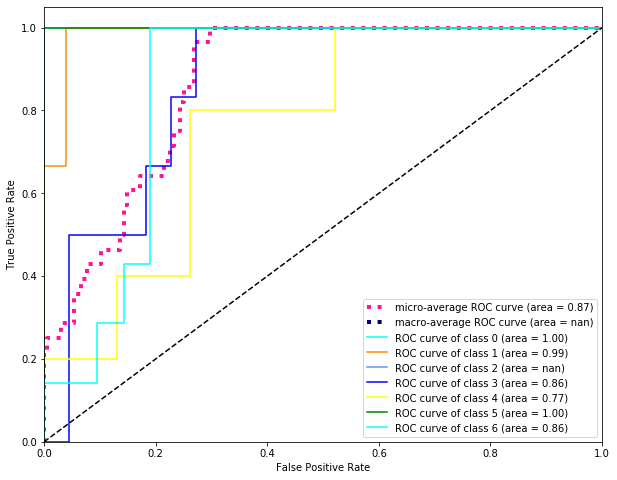

In [43]:
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(10,8))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue',"blue","yellow","green"])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, #lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()


#### ii. Repeat 1(f)i using a Na ̈ıve Bayes’ classifier. Use both Gaussian and Multi- nomial priors and compare the results.

In [44]:
from sklearn.naive_bayes import GaussianNB

In [45]:
def multi_Gau_NB_grid_search_cv():
    res=0
    best_k_number=0
    current_list=[]
    
    #i is the number of Time Seires, J is the number of Lambda we choose
    for i in range(1,21):
        df = train_data_split[i-1]

        X_train=df.iloc[:,1:].astype('float')
        min_max_scaler = MinMaxScaler()
        X_train_normalized=min_max_scaler.fit_transform(X_train)
        Y_train=df.iloc[:,0].astype('float')
        
#         print(X_train)
#         print(Y_train)
        
#         return
        
        cv_score=0
        current_best_k=0
        current_best_feature_number=0
        
        
        
        model=GaussianNB()
        scores = cross_val_score(model,X_train ,Y_train, cv=5)
        avg_scores=np.mean(scores)
#         print("When Time Series = "+str(i)+" CV scores is:"+str(avg_scores))

        if avg_scores>res:
            res=avg_scores
            best_k_number=i
                
    current_list.append((res,best_k_number))
                
                
    return current_list

Gau_NB_res=multi_Gau_NB_grid_search_cv()

/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/

In [46]:
Gau_NB_res

[(0.8406593406593406, 1)]

###### For the above result, we can find that The Gaussian Naive Bayes result are 84.0659% Accuracy

In [47]:
def multi_Mul_NB_grid_search_cv():
    res=0
    best_k_number=0
    best_lambda=0
    current_list=[]
    
    #i is the number of Time Seires, J is the number of Lambda we choose
    for i in range(1,21):
        df = train_data_split[i-1]
        X_train=df.iloc[:,1:].astype('float')
        min_max_scaler = MinMaxScaler()
        X_train_normalized=min_max_scaler.fit_transform(X_train)
        Y_train=df.iloc[:,0].astype('float')
        
        cv_score=0
        current_best_k=0
        current_best_feature_number=0
        
        
        for j in np.arange(1,10):
            model=MultinomialNB(alpha=j)
            scores = cross_val_score(model,X_train_normalized ,Y_train, cv=5)
            avg_scores=np.mean(scores)
            #print("When Time Series ="+str(i)+", Mutli NB Alpha ="+str(j)+" CV scores is"+str(avg_scores))
            
            if avg_scores>res:
                res=avg_scores
                best_k_number=i
                best_lambda=j
                
    current_list.append((res,best_k_number,best_lambda))
            
                
                
    return current_list

Mul_NB_res=multi_Mul_NB_grid_search_cv()

/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/

/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/

/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/

/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/

/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/ruiwenhe/opt/anaconda3/lib/python3.6/

In [48]:
Mul_NB_res

[(0.7384615384615385, 3, 1)]

###### From the above result,we can find that the Mul-NB has the 73.85% when Time Series=3, alpha=1

#### iii Which method is better for multi-class classification in this problem?

###### From this problem, we can find Gaussian Naive Bayes is best in this problem because it has 84.0659% accuracy